In [1]:
!pip install scikit-learn
!pip install openpyxl
!pip install imblearn
!pip install category_encoders
!pip install matplotlib
!pip install seaborn

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 37.0 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: /Library/Developer/

### Importing required libraries

In [2]:
# Required Libraries
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score,roc_curve, auc, precision_recall_curve,recall_score,precision_score, roc_curve,accuracy_score, confusion_matrix, classification_report, f1_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from category_encoders import BinaryEncoder
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.linear_model import LogisticRegression

### Constants and Functions

In [47]:
#####CONSTANTS####
USER='kanishkkaul'
FILE_PATH="file:///Users/{}/Downloads/".format(USER)
FILE_NAME="complain_master_dataset 2.csv"
CONSUMER_CONSENT_PROVIDED_BINARY_ENCONDING={
    # we are categorizing nan as a separate category -1
    'Consent provided': 1, 
    'Consent not provided': 0,
    'Consent withdrawn': 0,  # You can change this to -1 if you wish to handle it separately
    'Other': -1  # Treat 'Other' as a distinct category
}
CONSUMER_DISPUTED_BINARY_ENCODING={
    # we are categorizing nan as a separate category -1
    'Yes': 1,  # Disputed
    'No': 0    # Not disputed
}
COLS_NOT_IN_FEATURES=['Date received','Consumer complaint narrative','Company public response','ZIP code','Tags','Date sent to company','Timely response?','Complaint ID']
TARGET_LABELS = ['Closed with non-monetary relief', 'Closed with explanation',
       'In progress', 'Closed with monetary relief',
       'Closed without relief', 'Closed', 'Untimely response',
       'Closed with relief']
###COMMON FUNCTIONS####


    
def fixing_datatype(df):
    """
    :param df: This is the initial dataset we have read
    :return: Returns the dataset by enforcing the schema we have finalized
    """
    df['Company response to consumer'] = df['Company response to consumer'].astype(str)
    df=df.drop(columns=COLS_NOT_IN_FEATURES)
    return df


### Loading Dataset and enforcing schema

In [48]:
# 1. Load dataset from Excel file
  # Replace with your file path
df = pd.read_csv(FILE_PATH+FILE_NAME)
df=fixing_datatype(df)
df['Company response to consumer'].unique()

array(['Closed with non-monetary relief', 'Closed with explanation',
       'In progress', 'Closed with monetary relief',
       'Closed without relief', 'Closed', 'Untimely response',
       'Closed with relief', 'nan'], dtype=object)

### Feature Engineering

In [49]:

# 2. Preprocessing

#BOOLEAN COLUMNS

df['Consumer consent provided?'] = df['Consumer consent provided?'].replace(CONSUMER_CONSENT_PROVIDED_BINARY_ENCONDING)
# Handle NaN values by filling them with -1 (for unknown consent status) for Consumer Consent Provided column 
df['Consumer consent provided?']=df['Consumer consent provided?'].fillna(-1)
#  Treat NaN as a separate category (-1) for Consumer Disputed column
df['Consumer disputed?'] = df['Consumer disputed?'].replace(CONSUMER_DISPUTED_BINARY_ENCODING)
df['Consumer disputed?']=df['Consumer disputed?'].fillna(-1)

#CATEGORICAL COLUMN

# Frequency encoding: count the occurrences of each company for company column
df['Company'] = df['Company'].map(df['Company'].value_counts())
# Frequency encoding for product column
df['Product'] = df['Product'].map(df['Product'].value_counts())
# Treat NaN as a separate category as 'Unknown' for Sub-Product column
df['Sub-product']=df['Sub-product'].fillna('Unknown')
# Frequency encoding for Sub-Product column
df['Sub-product'] = df['Sub-product'].map(df['Sub-product'].value_counts())
# Treat NaN as a separate category as 'Unknown' for Issue column
df['Issue']=df['Issue'].fillna('Unknown')
# Frequency encoding for Issue column
df['Issue'] = df['Issue'].map(df['Issue'].value_counts())
# Treat NaN as 'Unknown' for Sub-Issue column
df['Sub-issue']=df['Sub-issue'].fillna('Unknown')
# Frequency encoding for Sub-Issue column
df['Sub-issue'] = df['Sub-issue'].map(df['Sub-issue'].value_counts())

#binary encoding for State column
df['State']=df['State'].fillna('Unknown')
encoder = BinaryEncoder(cols=['State'], return_df=True)
df_encoded = encoder.fit_transform(df['State'])
df = pd.concat([df, df_encoded], axis=1).drop('State', axis=1)

#one hot encoding for Submitted via column
encoder = OneHotEncoder()
# Apply one-hot encoding
encoded_data = encoder.fit_transform(df[['Submitted via']])
encoded_df = pd.DataFrame(encoded_data.toarray(), columns=encoder.get_feature_names_out(['Submitted via']))
# Concatenate the original DataFrame with the one-hot encoded columns
df = pd.concat([df, encoded_df], axis=1).drop(columns=['Submitted via'])


###TARGET VARIABLE


# Removing the nan from the target variable to prevent problems with undersampling 
df=df[~(df['Company response to consumer']=='nan')]

# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the target variable
df['Company response to consumer'] = label_encoder.fit_transform(df['Company response to consumer'])





/var/folders/1d/ncp_pp292x98rqr67_drq73w0000gn/T/ipykernel_60666/2621549205.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Consumer consent provided?'] = df['Consumer consent provided?'].replace(CONSUMER_CONSENT_PROVIDED_BINARY_ENCONDING)
/var/folders/1d/ncp_pp292x98rqr67_drq73w0000gn/T/ipykernel_60666/2621549205.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Consumer disputed?'] = df['Consumer disputed?'].replace(CONSUMER_DISPUTED_BINARY_ENCODING)


### Splitting data into training and testing

In [50]:
# 3. Split the data into training and testing sets

X = df.drop(columns=['Company response to consumer']) # Features (all columns except the last)
y = df['Company response to consumer']    # Target (last column)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

### Feature Selection


In [9]:
# Lasso feature selector
lasso = Lasso(alpha=0.1)
lasso.fit(X, y)

# Feature selection
selected_features = X.columns[(lasso.coef_ != 0).ravel().tolist()]
print("Selected Features:", selected_features)

X_train = X_train[selected_features]
X_test = X_test[selected_features]

Selected Features: Index(['Product', 'Sub-product', 'Issue', 'Sub-issue', 'Company',
       'Consumer consent provided?'],
      dtype='object')


### Feature Scaling 

In [10]:
# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler to the training data and transform it
X_train= scaler.fit_transform(X_train)

# Apply the same transformation to the test data
X_test= scaler.transform(X_test)

### Undersampling to handle class imbalance

In [11]:
# Check the class distribution before undersampling
print("Class distribution before undersampling:", Counter(y_train))

# Initialize RandomUnderSampler
rus = RandomUnderSampler(random_state=42)

# Apply undersampling on the training data
X_train_resampled, y_train_resampled = rus.fit_resample(X_train, y_train)

# Check the class distribution after undersampling
print("Class distribution after undersampling:", Counter(y_train_resampled))


Class distribution before undersampling: Counter({1: 465571, 3: 213040, 6: 45441, 2: 19740, 0: 2147, 5: 2109, 7: 1293, 4: 656})
Class distribution after undersampling: Counter({0: 656, 1: 656, 2: 656, 3: 656, 4: 656, 5: 656, 6: 656, 7: 656})


### Logistic Regression

In [ ]:
##Logistic regression
elastic_net = SGDClassifier(loss='log_loss', penalty='elasticnet', alpha=0.0001, l1_ratio=0.5)
elastic_net.fit(X_train, y_train)

# Predict on the test set
y_pred_en = elastic_net.predict(X_test)
y_pred_proba_en = elastic_net.predict_proba(X_test)[:, 1]  # Probabilities for the positive class

# Calculate weighted precision - weighting the precision of each class by the number of true instances for each class
weighted_precision = precision_score(y_test, y_pred_en, average='weighted')
# Calculate weighted recall - weighting the recall of each class by the number of true instances for each class
weighted_recall = recall_score(y_test, y_pred_en, average='weighted')

# Binarize the output classes for multiclass ROC AUC
y_test_binarized = label_binarize(y_test, classes=np.unique(y_test))
y_pred_proba_en_binarized = label_binarize(y_pred_en, classes=np.unique(y_test))

# Evaluate the model
print("Logistic Regression:")
print("Accuracy:", accuracy_score(y_test, y_pred_en))
print("F1 Score:", f1_score(y_test, y_pred_en, average='weighted'))
print("Weighted Precision:", weighted_precision)
print("Weighted Recall:", weighted_recall)
print("AUC vs ROC:", roc_auc_score(y_test_binarized, y_pred_proba_en_binarized, multi_class='ovr'))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_en))


Logistic Regression:
Accuracy: 0.7255989023956095
F1 Score: 0.6937371062223499
AUC vs ROC: 0.5912156193891938
Weighted Precision: 0.6968292845737847
Weighted Recall: 0.7255989023956095
Confusion Matrix:
 [[     0    687      0      0      0      0      0      0]
 [     0 141285      0  10723      0      0   2952      0]
 [     0   6289      0      0      0      0      0      0]
 [     0  39489      0  28486      0      0   3680      0]
 [     0    191      0      0      0      0      0      0]
 [     0    707      0      0      0      0      0      0]
 [     0   1719      0   1774      0      0  11628      0]
 [     0    389      0      0      0      0      0      0]]


/Users/kanishkkaul/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


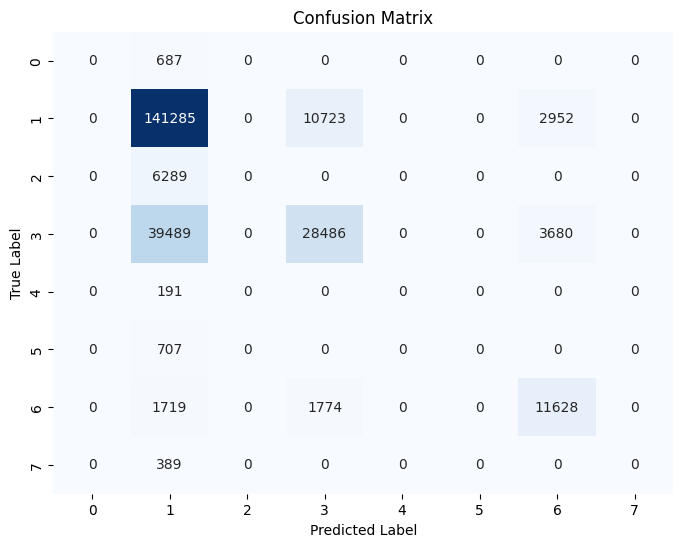

In [13]:
# Plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_en)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

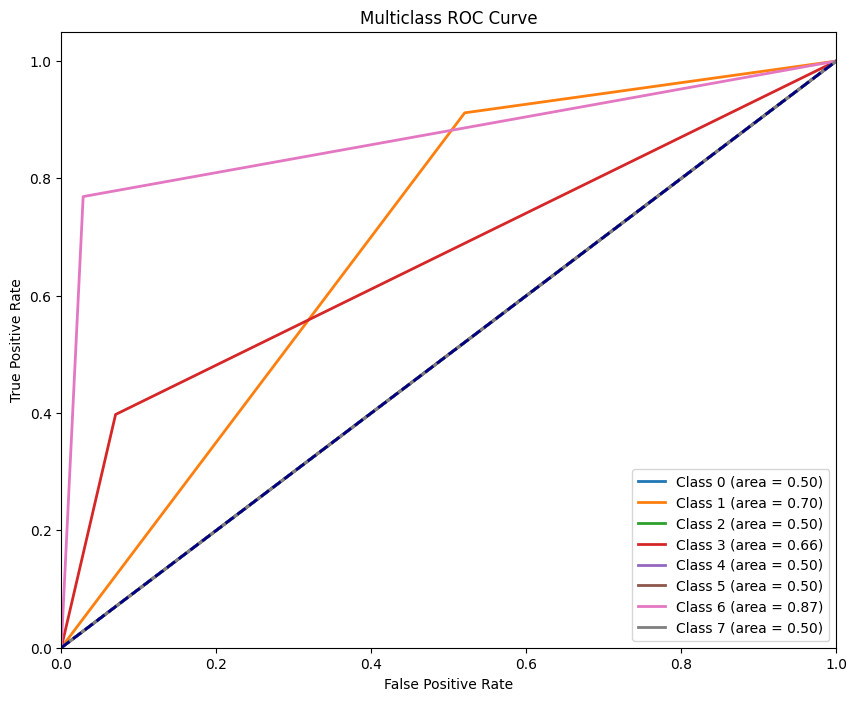

In [14]:
# Calculate ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len(np.unique(y_test))):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred_proba_en_binarized[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize=(10, 8))
for i in range(len(np.unique(y_test))):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {i} (area = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curve')
plt.legend(loc='lower right')
plt.show()


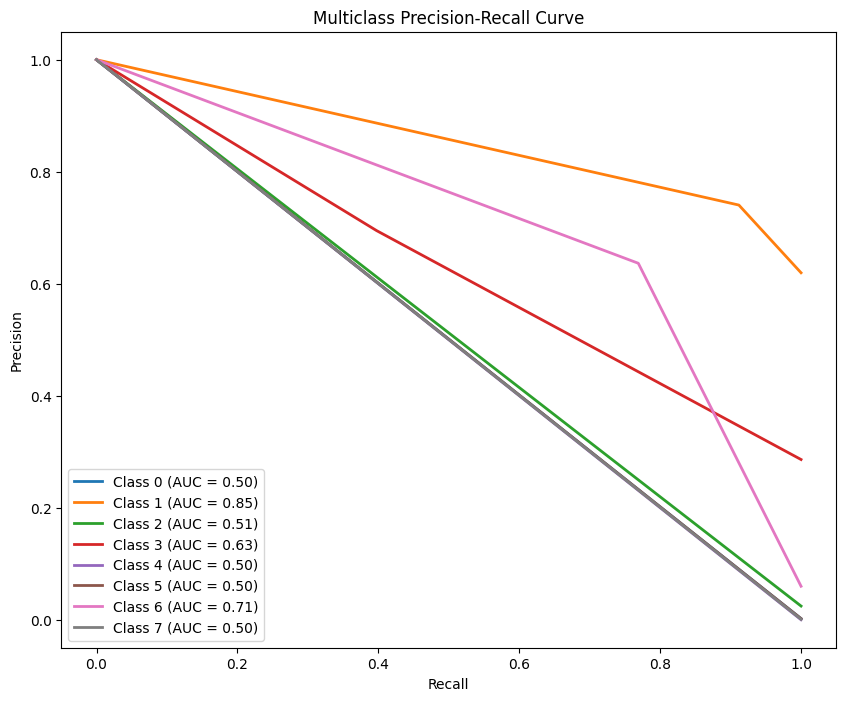

In [15]:
# Calculate precision-recall curve for each class
precision = dict()
recall = dict()
pr_auc = dict()

for i in range(len(np.unique(y_test))):
    precision[i], recall[i], _ = precision_recall_curve(y_test_binarized[:, i], y_pred_proba_en_binarized[:, i])
    pr_auc[i] = auc(recall[i], precision[i])

# Plot precision-recall curve for each class
plt.figure(figsize=(10, 8))
for i in range(len(np.unique(y_test))):
    plt.plot(recall[i], precision[i], lw=2, label=f'Class {i} (AUC = {pr_auc[i]:0.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Multiclass Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()


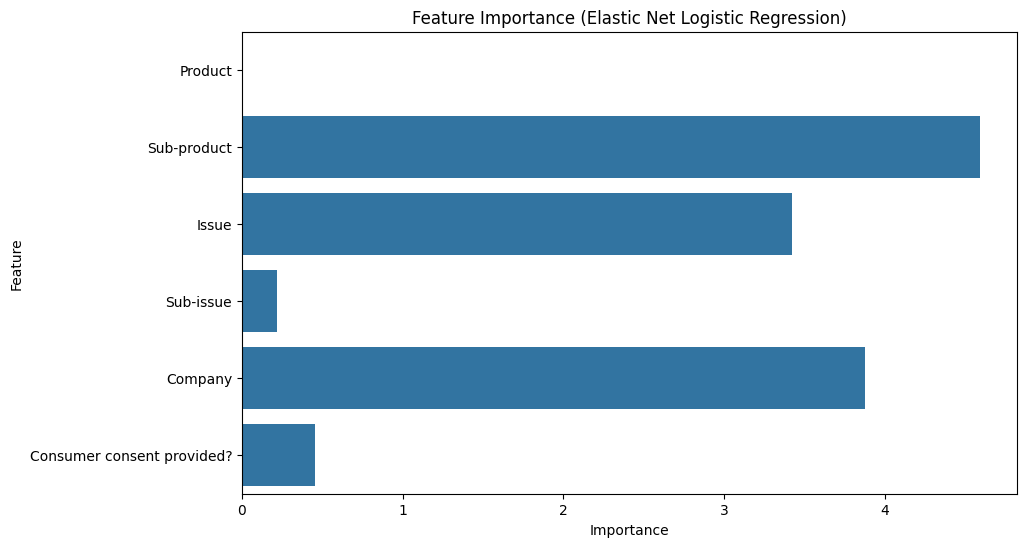

In [16]:
# Feature importance (absolute value of coefficients for Elastic Net regularization)
feature_importance = np.abs(elastic_net.coef_[0])  
features = selected_features  

# Create a bar plot for feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importance, y=features)
plt.title('Feature Importance (Elastic Net Logistic Regression)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

### Random forest classifier

In [17]:
# Initialize the Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)  # You can adjust n_estimators as needed

# Train the model
rf_classifier.fit(X_train, y_train)

# Predict on the test set
y_pred_rf = rf_classifier.predict(X_test)

# Predict probabilities (if you want to calculate ROC AUC)
y_pred_proba_rf = rf_classifier.predict_proba(X_test)  # Get the probabilities for the positive class

In [18]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred_rf)
print("Accuracy:", accuracy)

# Calculate F1 score
f1 = f1_score(y_test, y_pred_rf, average='weighted')  # Adjust 'average' based on your requirement
print("F1 Score:", f1)

#AUC vs ROC
# Calculate ROC AUC score (if your problem is binary or if you want to calculate multiclass ROC)
roc_auc = roc_auc_score(y_test, y_pred_proba_rf, multi_class='ovr')  # Adjust for multiclass if necessary
print("ROC AUC Score:", roc_auc)

# Calculate weighted precision - weighting the precision of each class by the number of true instances
precision_weighted = precision_score(y_test, y_pred_rf, average='weighted')
print("Weighted Precision:", precision_weighted)

# Calculate weighted recall - weighting the recall of each class by the number of true instances
recall_weighted = recall_score(y_test, y_pred_rf, average='weighted')
print("Weighted Recall:", recall_weighted)



# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_rf)
print("Confusion Matrix:\n", conf_matrix)


Accuracy: 0.7570710282841131
F1 Score: 0.7453737662467913
ROC AUC Score: 0.882472091020021
Weighted Precision: 0.745280101319774
Weighted Recall: 0.7570710282841131
Confusion Matrix:
 [[    84    541     16     41      2      0      0      3]
 [   181 135688   1338  14542      9     36   3015    151]
 [     9   5138    991    136      4      2      4      5]
 [    38  27315    159  40496      1      6   3630     10]
 [     0    166     21      3      1      0      0      0]
 [     0    669     20      5      2     11      0      0]
 [     0   1643     14   1518      0      0  11945      1]
 [     7    324      1      4      0      0      2     51]]


In [32]:
# Get feature importances
importances = rf_classifier.feature_importances_

# Create a DataFrame to see feature importances
feature_importance_df = pd.DataFrame({'Feature': selected_features, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
print(feature_importance_df)


                      Feature  Importance
4                     Company    0.462075
0                     Product    0.187551
5  Consumer consent provided?    0.138418
1                 Sub-product    0.079701
2                       Issue    0.068895
3                   Sub-issue    0.063360


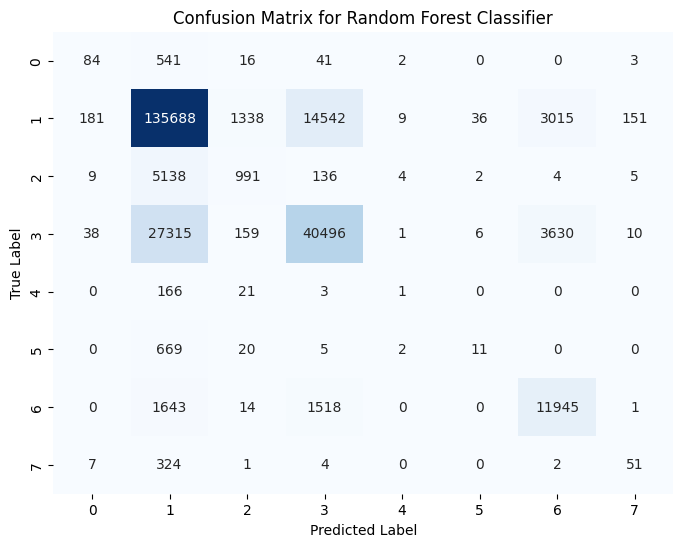

In [34]:

# Plot confusion matrix using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.title('Confusion Matrix for Random Forest Classifier')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

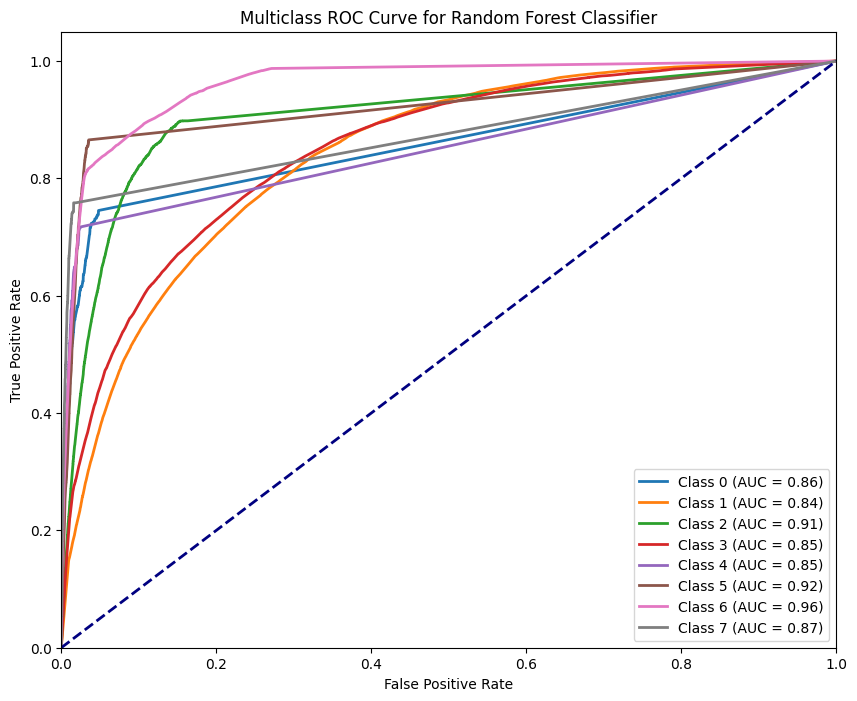

In [21]:
# Calculate ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len(np.unique(y_test))):
    fpr[i], tpr[i], _ = roc_curve(y_test == i, y_pred_proba_rf[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize=(10, 8))
for i in range(len(np.unique(y_test))):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {i} (AUC = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curve for Random Forest Classifier')
plt.legend(loc='lower right')
plt.show()


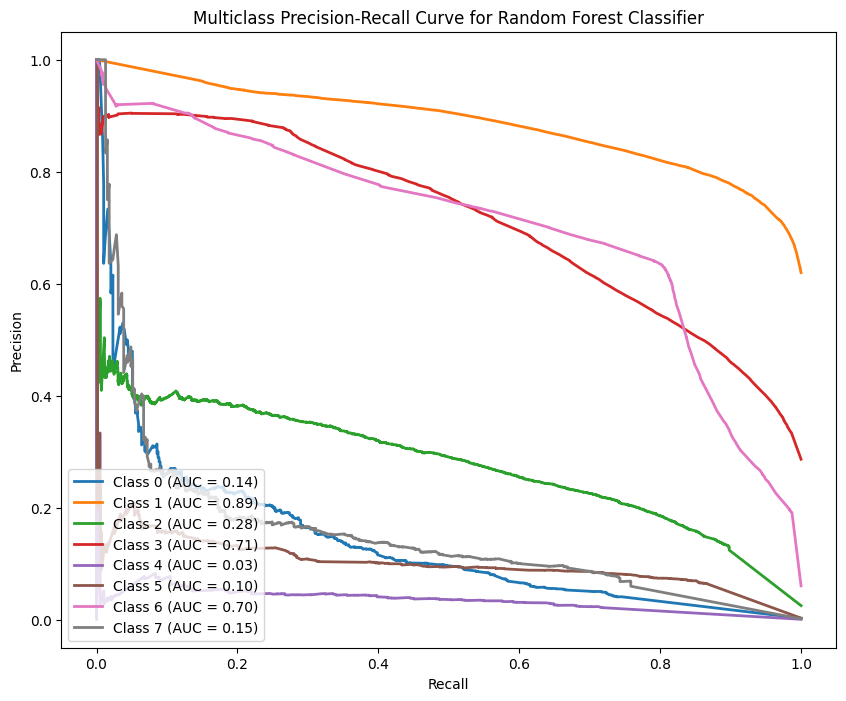

In [22]:
# Calculate precision-recall curve for each class
precision = dict()
recall = dict()
pr_auc = dict()

for i in range(len(np.unique(y_test))):
    precision[i], recall[i], _ = precision_recall_curve(y_test == i, y_pred_proba_rf[:, i])
    pr_auc[i] = auc(recall[i], precision[i])

# Plot precision-recall curve for each class
plt.figure(figsize=(10, 8))
for i in range(len(np.unique(y_test))):
    plt.plot(recall[i], precision[i], lw=2, label=f'Class {i} (AUC = {pr_auc[i]:0.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Multiclass Precision-Recall Curve for Random Forest Classifier')
plt.legend(loc='lower left')
plt.show()


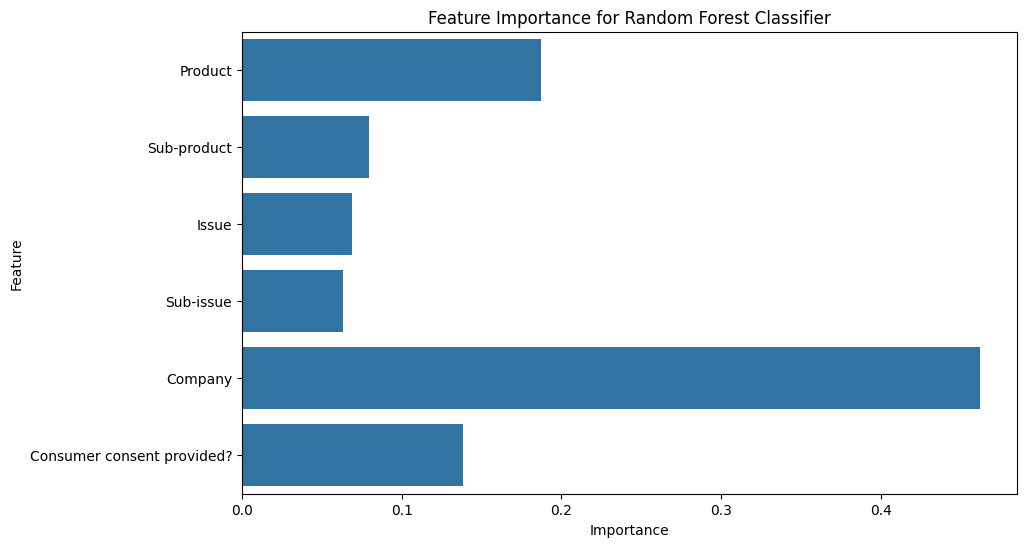

In [23]:
# Visualize feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x=importances, y=selected_features)
plt.title('Feature Importance for Random Forest Classifier')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()


# Distribution of Target Variable - Before Undersampling/ After Sampling

In [73]:

def plot_target_distribution_before_after_improved(y_original, y_undersampled, target_labels):
    fig, axes = plt.subplots(1, 2, figsize=(16, 8), sharey=True)

    # Colors for differentiation
    color_before = 'skyblue'
    color_after = 'salmon'
    
    # Plot the distribution before undersampling with logarithmic y-axis
    sns.histplot(y_original, bins=len(target_labels), kde=False, ax=axes[0], color=color_before)
    axes[0].set_title("Distribution of Target Variable - Before Undersampling", fontsize=16)
    axes[0].set_xlabel("Company Response Type", fontsize=14)
    axes[0].set_ylabel("Frequency (Log Scale)", fontsize=14)
    axes[0].set_yscale('log')  # Apply logarithmic scale to y-axis for clarity
    axes[0].set_xticks(range(len(target_labels)))
    axes[0].set_xticklabels(target_labels, rotation=45, ha="right", fontsize=12)

    # Display counts on top of bars
    for p in axes[0].patches:
        axes[0].annotate(f'{int(p.get_height())}', 
                         (p.get_x() + p.get_width() / 2, p.get_height()), 
                         ha='center', va='bottom', fontsize=10, color='black')

    # Plot the distribution after undersampling with logarithmic y-axis
    sns.histplot(y_undersampled, bins=len(target_labels), kde=False, ax=axes[1], color=color_after)
    axes[1].set_title("Distribution of Target Variable - After Undersampling", fontsize=16)
    axes[1].set_xlabel("Company Response Type", fontsize=14)
    axes[1].set_yscale('log')  # Keep the logarithmic scale consistent
    axes[1].set_xticks(range(len(target_labels)))
    axes[1].set_xticklabels(target_labels, rotation=45, ha="right", fontsize=12)

    # Display counts on top of bars
    for p in axes[1].patches:
        axes[1].annotate(f'{int(p.get_height())}', 
                         (p.get_x() + p.get_width() / 2, p.get_height()), 
                         ha='center', va='bottom', fontsize=10, color='black')

    # Adjust layout
    plt.tight_layout()
    plt.show()

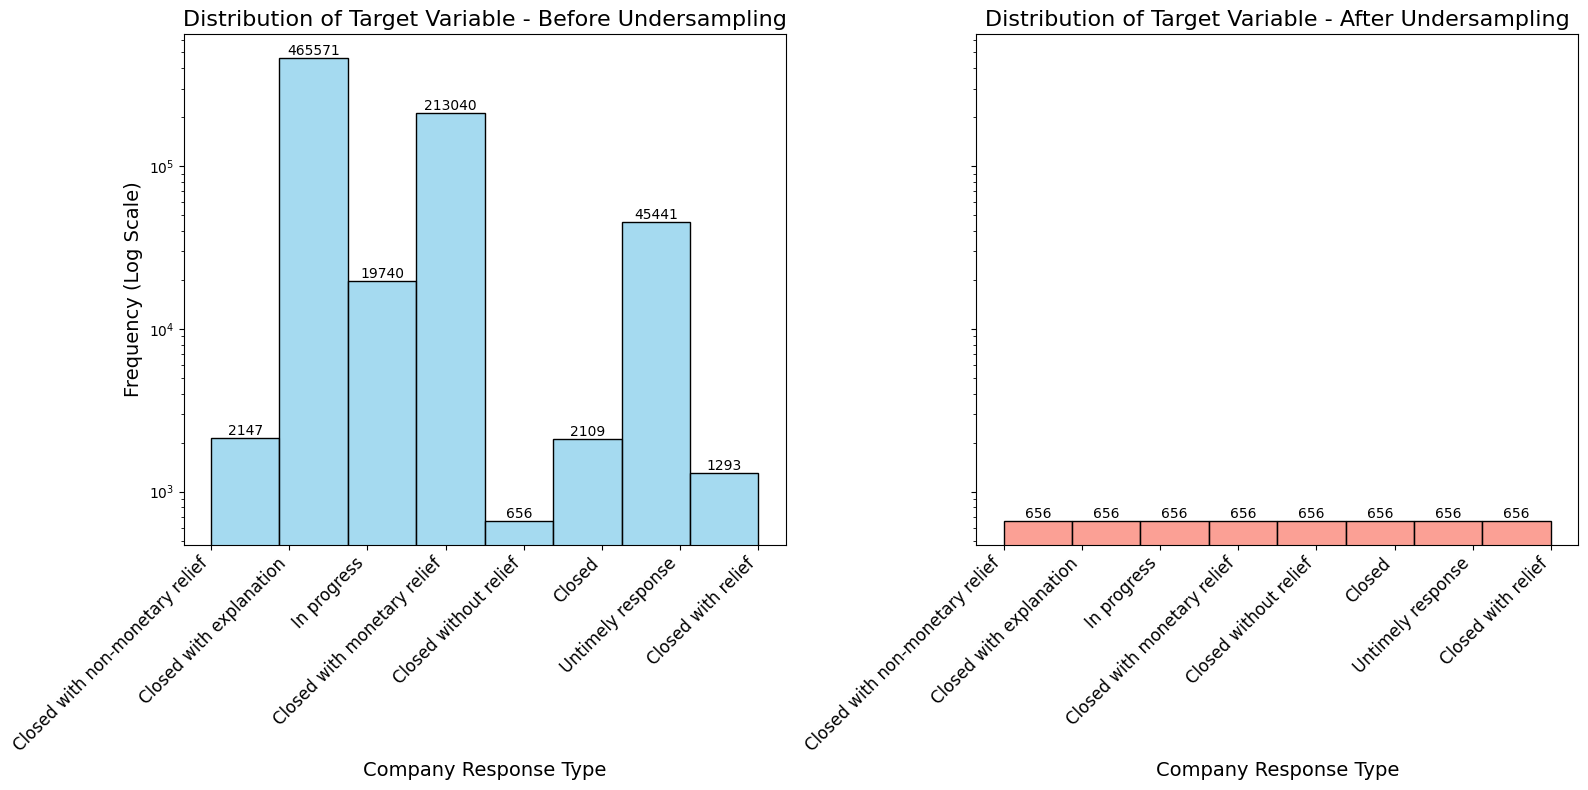

In [74]:
plot_target_distribution_before_after_improved(y_train, y_train_resampled, TARGET_LABELS)

# Comparison of Evaluation Metrics for Logistic Regression and Random Forest

/Users/kanishkkaul/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


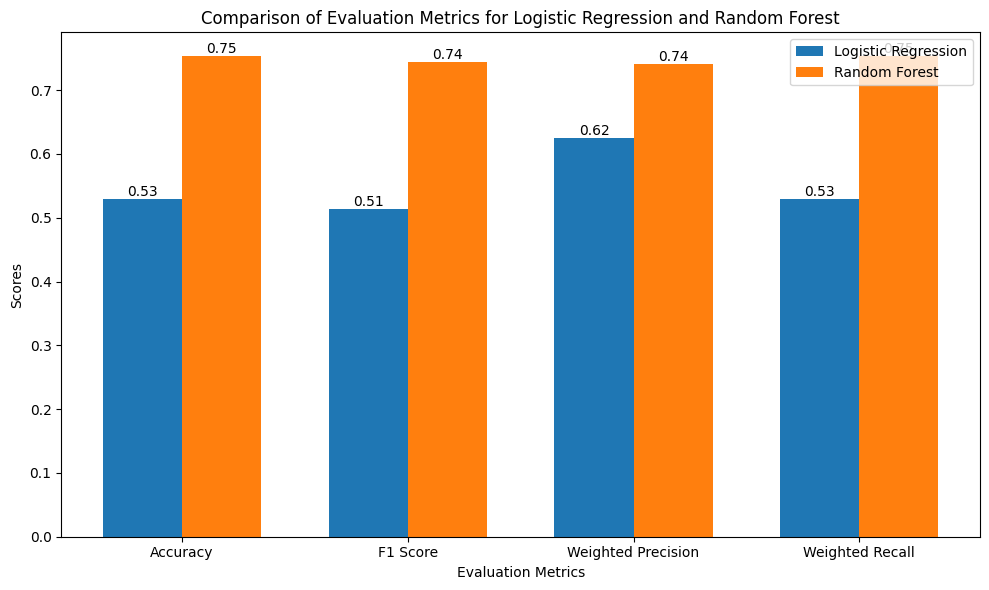

In [ ]:

# Logistic Regression (Elastic Net)
elastic_net = SGDClassifier(loss='log_loss', penalty='elasticnet', alpha=0.0001, l1_ratio=0.5)
elastic_net.fit(X_train, y_train)
y_pred_en = elastic_net.predict(X_test)

# Calculate metrics for Logistic Regression
accuracy_en = accuracy_score(y_test, y_pred_en)
f1_en = f1_score(y_test, y_pred_en, average='weighted')
precision_en = precision_score(y_test, y_pred_en, average='weighted')
recall_en = recall_score(y_test, y_pred_en, average='weighted')

# Random Forest Classifier
random_forest = RandomForestClassifier()
random_forest.fit(X_train, y_train)
y_pred_rf = random_forest.predict(X_test)

# Calculate metrics for Random Forest
accuracy_rf = accuracy_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf, average='weighted')
precision_rf = precision_score(y_test, y_pred_rf, average='weighted')
recall_rf = recall_score(y_test, y_pred_rf, average='weighted')

# Store the metrics in lists for plotting
metrics = ['Accuracy', 'F1 Score', 'Weighted Precision', 'Weighted Recall']
logistic_regression_scores = [accuracy_en, f1_en, precision_en, recall_en]
random_forest_scores = [accuracy_rf, f1_rf, precision_rf, recall_rf]

# Set up bar positions
x = np.arange(len(metrics))  # Label locations
width = 0.35  # Width of the bars

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

# Bar chart for Logistic Regression
bars1 = ax.bar(x - width/2, logistic_regression_scores, width, label='Logistic Regression')

# Bar chart for Random Forest
bars2 = ax.bar(x + width/2, random_forest_scores, width, label='Random Forest')

# Add labels, title, and custom x-axis tick labels
ax.set_xlabel('Evaluation Metrics')
ax.set_ylabel('Scores')
ax.set_title('Comparison of Evaluation Metrics for Logistic Regression and Random Forest')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

# Display the values on top of the bars
for bar in bars1 + bars2:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, yval, f'{yval:.2f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Spider Chart for Model Metric Comaprisson

/Users/kanishkkaul/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


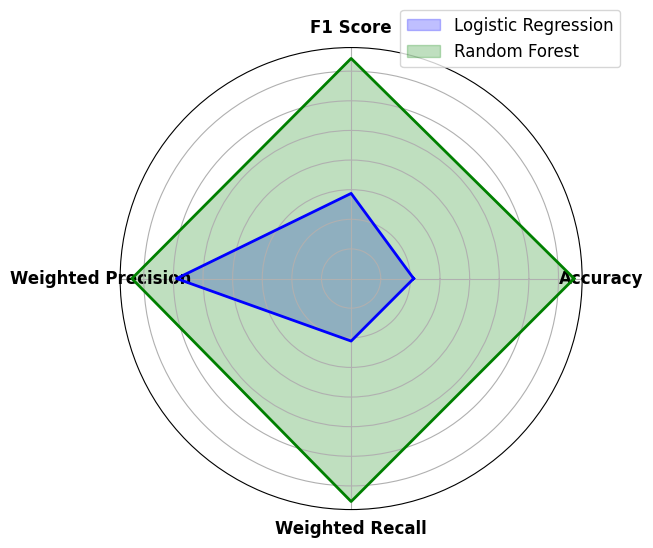

In [ ]:

# Logistic Regression (Elastic Net)
elastic_net = SGDClassifier(loss='log_loss', penalty='elasticnet', alpha=0.0001, l1_ratio=0.5)
elastic_net.fit(X_train, y_train)
y_pred_en = elastic_net.predict(X_test)

# Calculate metrics for Logistic Regression
accuracy_en = accuracy_score(y_test, y_pred_en)
f1_en = f1_score(y_test, y_pred_en, average='weighted')
precision_en = precision_score(y_test, y_pred_en, average='weighted')
recall_en = recall_score(y_test, y_pred_en, average='weighted')

# Random Forest Classifier
random_forest = RandomForestClassifier()
random_forest.fit(X_train, y_train)
y_pred_rf = random_forest.predict(X_test)

# Calculate metrics for Random Forest
accuracy_rf = accuracy_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf, average='weighted')
precision_rf = precision_score(y_test, y_pred_rf, average='weighted')
recall_rf = recall_score(y_test, y_pred_rf, average='weighted')

# Metrics and scores for radar chart
metrics = ['Accuracy', 'F1 Score', 'Weighted Precision', 'Weighted Recall']
logistic_regression_scores = [accuracy_en, f1_en, precision_en, recall_en]
random_forest_scores = [accuracy_rf, f1_rf, precision_rf, recall_rf]

# Number of metrics
num_vars = len(metrics)

# Compute angle for each axis
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]  # Close the loop

# Close the score lists for radar chart loop
logistic_regression_scores += logistic_regression_scores[:1]
random_forest_scores += random_forest_scores[:1]

# Initialize radar chart
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))

# Plot Logistic Regression
ax.fill(angles, logistic_regression_scores, color='blue', alpha=0.25, label='Logistic Regression')
ax.plot(angles, logistic_regression_scores, color='blue', linewidth=2)

# Plot Random Forest
ax.fill(angles, random_forest_scores, color='green', alpha=0.25, label='Random Forest')
ax.plot(angles, random_forest_scores, color='green', linewidth=2)

# Set labels for each axis
ax.set_yticklabels([])  # Hide radial labels for clarity
ax.set_xticks(angles[:-1])
ax.set_xticklabels(metrics, fontsize=12, fontweight='bold')

# Improve readability
plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1), fontsize=12)

# Show plot
plt.show()